# Lab - Recommender System


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process

### 1.1 - Movielens full - EDA
Nu ska du ladda ned datasetet ml-latest.zip under sektionen "recommended for education and
development". Ladda in dataseten "movies.csv" och "ratings.csv" besvara på följande frågor:

a) Gör en EDA för att förstå datasetet. Inkludera olika slags plots. Begränsa dig inte till frågorna nedan,
utan försök undersöka fler aspekter av datan.

In [69]:
movies = pd.read_csv("../../Data/ml-latest/movies.csv")
ratings = pd.read_csv("../../Data/ml-latest/ratings.csv")

In [10]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


In [12]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [11]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [70]:
ratings["movieId"].nunique() # Checks the number of movies in the dataset

53889

In [71]:
print(movies["movieId"].nunique()) 

58098


There are movies in the movies dataset that are not included in the ratings dataset (see below). Since I would like to explore the number of movies from each genre I remove the movies with no ratings, prior to analysis. 

In [24]:
movies[~movies["movieId"].isin(ratings["movieId"])]

,movieId,title,genres
8403,25817,Break of Hearts (1935),Drama|Romance
8800,26361,Baby Blue Marine (1976),Drama
9221,27153,Can't Be Heaven (Forever Together) (2000),Children|Comedy|Drama|Romance
9336,27433,Bark! (2002),Comedy|Drama
9809,31945,Always a Bridesmaid (2000),Documentary
...,...,...,...
57522,192399,Under Wraps (1997),Children|Comedy|Horror
57718,192933,Rosie (2018),Drama
57773,193109,Ach śpij kochanie (2017),Crime|Thriller
57854,193321,Pledges (2018),Comedy|Horror


In [27]:
movies = movies[movies["movieId"].isin(ratings["movieId"])]
len(movies)

53889

Next, I want to examine the different genres represented in the dataset and the number of movies from each genre. A movie can be a part of several genres and can therefore be counted several times. 

In [28]:
# Picks out the unique genres

all_genres = movies["genres"].unique() # Picks out all unique combinations of genres to ease the loop
genres = []

for genre in all_genres:
    genres.extend(genre.split("|")) 

unique_genres = list(set(genres)) # Picks out the unique genres
unique_genres.remove("(no genres listed)")
print(unique_genres)

['War', 'Comedy', 'Crime', 'Drama', 'IMAX', 'Mystery', 'Adventure', 'Documentary', 'Thriller', 'Film-Noir', 'Horror', 'Romance', 'Western', 'Sci-Fi', 'Musical', 'Children', 'Animation', 'Fantasy', 'Action']


In [31]:
# Count the number of occurences for each genre

number_of_occurences = []

for genre in unique_genres:
    number_of_occurences.append(movies["genres"].str.count(genre).sum())

print(number_of_occurences)

[1686, 14961, 4719, 22586, 197, 2574, 3738, 4919, 7736, 360, 5231, 6888, 1092, 3317, 1075, 2665, 2640, 2558, 6568]


In [40]:
genres_occurences = pd.DataFrame({"Genre":unique_genres, "Occurences":number_of_occurences}).sort_values("Occurences")
genres_occurences

,Genre,Occurences
4,IMAX,197
9,Film-Noir,360
14,Musical,1075
12,Western,1092
0,War,1686
17,Fantasy,2558
5,Mystery,2574
16,Animation,2640
15,Children,2665
13,Sci-Fi,3317


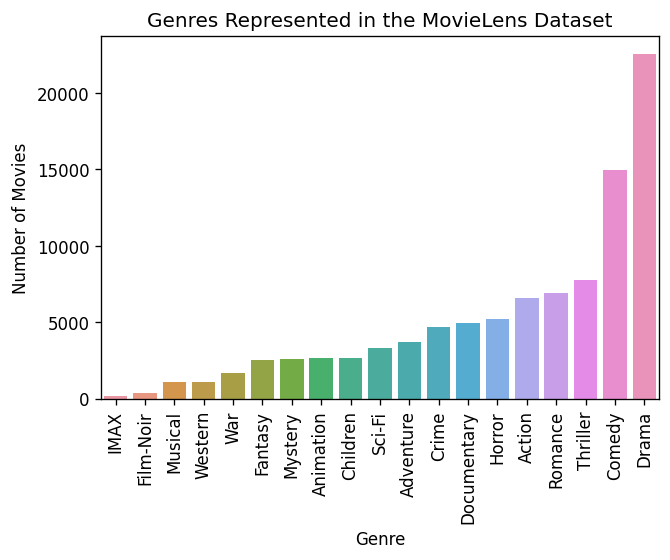

In [42]:
fig = plt.figure(dpi=120)
ax = sns.barplot(x=genres_occurences["Genre"], y=genres_occurences["Occurences"])

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
_ = ax.set(title="Genres Represented in the MovieLens Dataset", ylabel="Number of Movies")

I would also like to explore the mean rating per genre. Again, a movie can be counted several times if it belongs to several genres.

In [43]:
# Calculates mean rating per genre

mean_ratings = pd.DataFrame(ratings["rating"].groupby(ratings["movieId"]).mean()).reset_index() # Calculates mean rating for each movie
mean_ratings = mean_ratings.merge(movies, how="left", on="movieId") # Add title and genre 
means = [] # List to save the mean values for each genre

for genre in unique_genres: # Loops through the unique genres
    temp = pd.DataFrame({"movieId" : mean_ratings["movieId"], 
                        "Mean_rating" : mean_ratings["rating"],
                        "Contains_value" : mean_ratings["genres"].str.contains(genre)}) # Check if the string contains the genre or not

    temp = pd.DataFrame(temp["Mean_rating"].groupby(temp["Contains_value"]).mean().reset_index()) # Return the mean rating, based on the specific genre (value is True)
    
    means.append(temp["Mean_rating"][1]) # [1] is the second row in the dataframe, Contains_value is True

genres_rating = pd.DataFrame({"Genre":unique_genres, "Mean Rating":means}).sort_values("Mean Rating")
genres_rating

,Genre,Mean Rating
10,Horror,2.595426
13,Sci-Fi,2.769681
18,Action,2.910727
8,Thriller,2.912710
6,Adventure,3.006427
15,Children,3.006498
12,Western,3.022282
17,Fantasy,3.035745
5,Mystery,3.039553
1,Comedy,3.051817


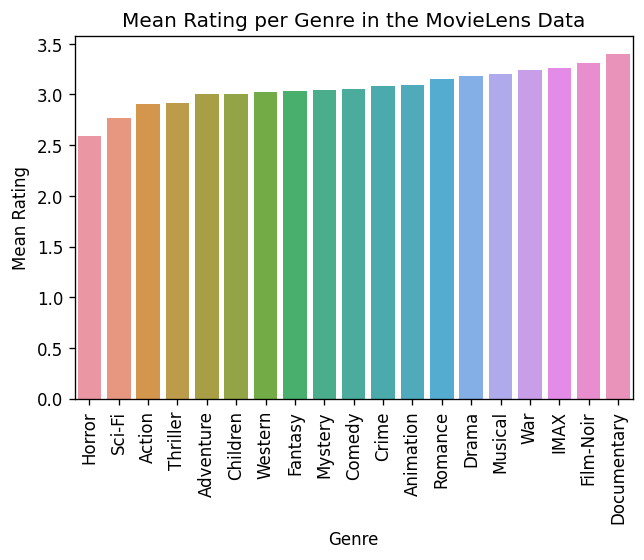

In [44]:
fig = plt.figure(dpi=120)
ax = sns.barplot(x=genres_rating["Genre"], y=genres_rating["Mean Rating"])

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
_ = ax.set(title="Mean Rating per Genre in the MovieLens Data")

b) Vilka är de 10 filmerna med flest ratings?

In [46]:
most_ratings = ratings["rating"].groupby(ratings["movieId"]).count()

most_ratings = pd.DataFrame(most_ratings.sort_values(ascending=False).head(10)).reset_index()
most_ratings = most_ratings.rename({"rating":"Number of Ratings"}, axis=1)

movies_most_ratings = pd.merge(most_ratings, 
                            movies.loc[movies["movieId"].isin(most_ratings["movieId"])], 
                            on="movieId"
                            )
movies_most_ratings

,movieId,Number of Ratings,title,genres
0,318,97999,"Shawshank Redemption, The (1994)",Crime|Drama
1,356,97040,Forrest Gump (1994),Comedy|Drama|Romance|War
2,296,92406,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,593,87899,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,2571,84545,"Matrix, The (1999)",Action|Sci-Fi|Thriller
5,260,81815,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
6,480,76451,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
7,527,71516,Schindler's List (1993),Drama|War
8,110,68803,Braveheart (1995),Action|Drama|War
9,1,68469,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


c) Beräkna den genomsnittliga ratingen för dessa 10 filmerna med flest ratings.

In [47]:
rating_of_most_rated = ratings.loc[ratings["movieId"].isin(most_ratings["movieId"])]
rating_of_most_rated = rating_of_most_rated["rating"].groupby(rating_of_most_rated["movieId"]).mean()

In [48]:
movies_most_rated = pd.merge(movies_most_ratings, 
                            pd.DataFrame({"Mean Rating":rating_of_most_rated}).reset_index(), 
                            on="movieId")
movies_most_rated

,movieId,Number of Ratings,title,genres,Mean Rating
0,318,97999,"Shawshank Redemption, The (1994)",Crime|Drama,4.424188
1,356,97040,Forrest Gump (1994),Comedy|Drama|Romance|War,4.056585
2,296,92406,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.173971
3,593,87899,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.151412
4,2571,84545,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.149695
5,260,81815,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.120455
6,480,76451,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.665034
7,527,71516,Schindler's List (1993),Drama|War,4.257502
8,110,68803,Braveheart (1995),Action|Drama|War,4.008481
9,1,68469,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.886649


d) Gör en plot över årtal och antalet filmer representerade i datasettet.

In [49]:
year_of_movies = movies["title"].str.extract(r"(\(\d{4}\))") # Extract all years in the format (dddd)
year_of_movies = year_of_movies[0].str.extract(r"(\d{4})").rename({0:"Year"}, axis=1) # Removes the parantheses
year_of_movies = pd.DataFrame(year_of_movies["Year"].dropna().astype(int))
year_of_movies

,Year
0,1995
1,1995
2,1995
3,1995
4,1995
...,...
58093,1946
58094,2011
58095,2016
58096,2017


In [50]:
movies_per_year = pd.DataFrame(year_of_movies["Year"].value_counts()).rename({"Year":"Count"}, axis=1)
movies_per_year = movies_per_year.drop(2018) # Remove 2018, since the data is insufficient for this year (dataset was updated 9/2018)
movies_per_year

,Count
2015,2233
2014,2205
2016,2143
2013,2115
2012,1956
...,...
1887,1
1878,1
1874,1
1883,1


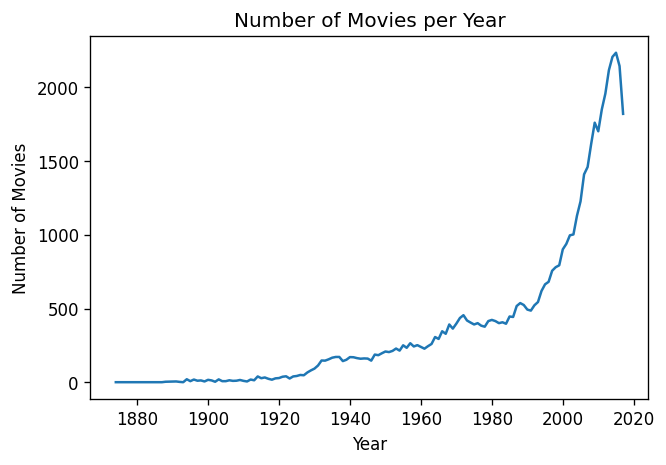

In [51]:
fig = plt.figure(dpi=120)
ax = sns.lineplot(x=movies_per_year.index, y=movies_per_year["Count"])
_ = ax.set(title="Number of Movies per Year", xlabel="Year", ylabel="Number of Movies")

In [52]:
movies.loc[movies["title"].str.contains("1874", case=False)]

,movieId,title,genres
37886,148054,Passage de Venus (1874),Documentary


e) Gör en plot över antalet ratings mot movieId.

In [53]:
ratings_per_movieId = pd.DataFrame(ratings["rating"].groupby(ratings["movieId"]).count()).reset_index()
ratings_per_movieId

,movieId,rating
0,1,68469
1,2,27143
2,3,15585
3,4,2989
4,5,15474
...,...,...
53884,193876,1
53885,193878,1
53886,193880,1
53887,193882,1


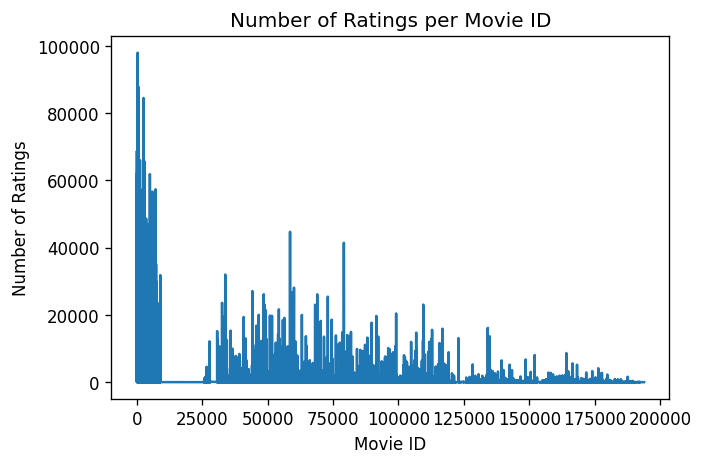

In [54]:
fig = plt.figure(dpi=120)
ax = sns.lineplot(x=ratings_per_movieId["movieId"], y=ratings_per_movieId["rating"])
_ = ax.set(title="Number of Ratings per Movie ID", xlabel="Movie ID", ylabel="Number of Ratings")

f) Beräkna genomsnittliga ratings för de top 10 filmerna med flest ratings. Gör ett stapeldiagram över
dessa.

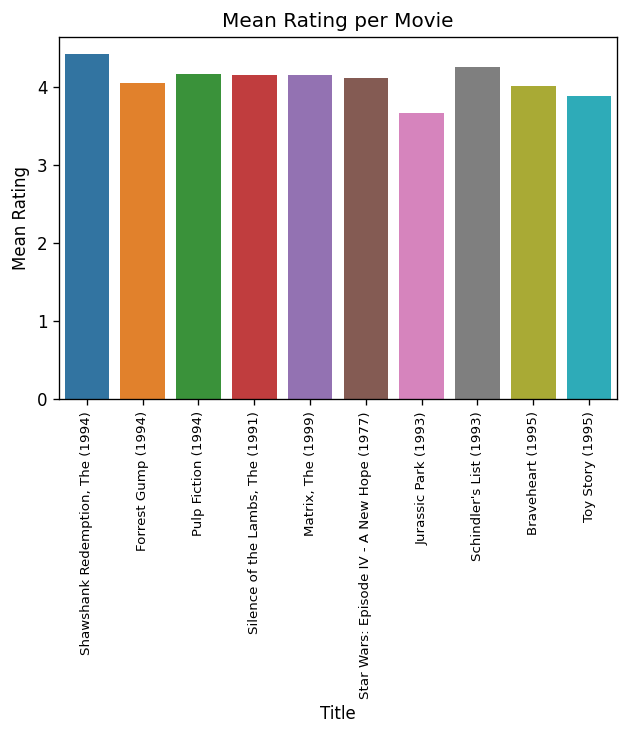

In [55]:
fig = plt.figure(dpi=120)
ax = sns.barplot(x=movies_most_rated["title"], y=movies_most_rated["Mean Rating"])
ax.set(title="Mean Rating per Movie", xlabel="Title")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size=8)

### 1.2 Skapa gles matris
Likt i videon i uppgift 1.0 skapade du en pivottabell av dataframet med index "movieId", columns "userId"
och values "ratings". Denna pivottabell är dock "dyrt" att skapa och förmodligen kommer inte din dator att
klara av skapa den om du inte filtrerar bort viss data. Fundera ut ett lämpligt sätt att filtrera ditt dataset,
prova dig fram och motivera.
Skapa en gles (sparse) matris med hjälp av denna pivottabell.

In [68]:
ratings = ratings.drop("timestamp", axis=1) # Drops the timestamp column
ratings

KeyError: "['timestamp'] not found in axis"

In [63]:
# Calculates the number of ratings per movie
number_of_ratings = pd.DataFrame(ratings["rating"].groupby(ratings["movieId"]).count()).reset_index()
number_of_ratings["rating"].describe()

count    53889.000000
mean       515.011301
std       2934.758939
min          1.000000
25%          2.000000
50%          7.000000
75%         48.000000
max      97999.000000
Name: rating, dtype: float64

In [60]:
few_ratings = number_of_ratings[number_of_ratings["rating"] <= 48]

reduced_ratings = ratings[~ratings['movieId'].isin(few_ratings.index)]

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5
...,...,...,...
27753438,283228,8228,5.0
27753439,283228,8542,4.5
27753441,283228,34405,4.5
27753442,283228,44761,4.5


75 % of the movies have a mean rating under 48. I choose to base my decision on the median, rather than the mean, since the data seems to be skewed with some very popular movies that increases the mean. I therefore drop all movies that have been rated 48 or fewer times. It does not seem reasonable to recommend a movie based on very few recommendations (since then one rating of 5 would give it a top mean rating). I also considered basing this rating on 7 (50%), but this still seems a bit too low, and would still introduce uncertainty in the mean rating. I believe 48 is still low enough to capture a variety of movies. 

In [6]:
few_ratings = number_of_ratings[number_of_ratings["rating"] <= 48]

reduced_ratings = ratings[~ratings['movieId'].isin(few_ratings.index)]
reduced_ratings

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5
...,...,...,...
27753439,283228,8542,4.5
27753440,283228,8712,4.5
27753441,283228,34405,4.5
27753442,283228,44761,4.5


This reduced the number of rows from 27,753,444 to 27,435,354, which is still not low enough for pivot to work. I therefore continue to check the mean ratings for the movies, since I do not want to recommend "bad movies".

In [7]:
# Calculates the mean ratings for movies
mean_ratings = pd.DataFrame(reduced_ratings["rating"].groupby(reduced_ratings["movieId"]).mean())
mean_ratings["rating"].describe()

count    13454.000000
mean         3.276252
std          0.485519
min          0.873950
25%          2.991304
50%          3.345979
75%          3.637393
max          4.486518
Name: rating, dtype: float64

I would not like the recommendation system to recommend very "bad movies" and I therefore decide to remove around 25% of the movies, with the lowest mean ratings. 

In [8]:
low_ratings = mean_ratings[mean_ratings["rating"] < 3]

reduced_ratings = reduced_ratings[~reduced_ratings['movieId'].isin(low_ratings.index)]
reduced_ratings

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
3,1,1257,4.5
4,1,1449,4.5
7,1,2134,4.5
...,...,...,...
27753439,283228,8542,4.5
27753440,283228,8712,4.5
27753441,283228,34405,4.5
27753442,283228,44761,4.5


This reduced the number of rows from 27,435,354 to 23,888,004 which is still not low enough for pivot to work. One effective way to remove the last rows for it to work is to remove users with few ratings. 

In [9]:
users_with_few_ratings = pd.DataFrame(ratings["movieId"].groupby(ratings["userId"]).count())
users_with_few_ratings["movieId"].describe()
# Somewhat noteworthy is that there is a user who has given 23715 ratings.

count    283228.000000
mean         97.989761
std         212.760722
min           1.000000
25%          15.000000
50%          30.000000
75%          95.000000
max       23715.000000
Name: movieId, dtype: float64

In [10]:
users_with_few_ratings = users_with_few_ratings[users_with_few_ratings["movieId"] <= 15]

reduced_ratings = reduced_ratings[~reduced_ratings['movieId'].isin(users_with_few_ratings.index)]
reduced_ratings

,userId,movieId,rating
1,1,481,3.5
3,1,1257,4.5
7,1,2134,4.5
8,1,2478,4.0
9,1,2840,3.0
...,...,...,...
27753437,283228,7834,5.0
27753438,283228,8228,5.0
27753439,283228,8542,4.5
27753440,283228,8712,4.5


I also change the datatype so that the data should take less memory. 

In [21]:
print(ratings["userId"].max())
print(ratings["userId"].min())
print(ratings["movieId"].max())
print(ratings["movieId"].min())

283228
1
193886
1


In [22]:
reduced_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17174637 entries, 1 to 27753441
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 524.1 MB


In [11]:
reduced_ratings = reduced_ratings.astype({"userId": np.int32, "movieId": np.int32, "rating": np.float32})

In [12]:
reduced_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17174637 entries, 1 to 27753441
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 327.6 MB


In [13]:
# Run pivot on the reduced data
movies_users = reduced_ratings.pivot(index="movieId", columns="userId", values="rating").fillna(0)

In [14]:
movies_users

userId,1,2,3,4,5,6,7,8,9,10,...,283219,283220,283221,283222,283223,283224,283225,283226,283227,283228
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5
5,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
189873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
190089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
# Creates sparse dataset
movies_users_sparse = csr_matrix(movies_users.values)
print(movies_users_sparse)

NameError: name 'movies_users' is not defined

In [90]:
# Reset index for the pivoted data, so that movieId can be reached
movies_users = movies_users.reset_index()
movies_users

userId,movieId,1,2,3,4,5,6,7,8,9,...,283219,283220,283221,283222,283223,283224,283225,283226,283227,283228
0,1,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5
1,5,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7120,189783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7121,189873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7122,190089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7123,191351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Reduce the movie data so that the movies and indexes are the same as in the pivoted data
movies_reduced = movies.loc[movies["movieId"].isin(reduced_ratings["movieId"])].reset_index(drop=True)
movies_reduced

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,Father of the Bride Part II (1995),Comedy
2,6,Heat (1995),Action|Crime|Thriller
3,8,Tom and Huck (1995),Adventure|Children
4,10,GoldenEye (1995),Action|Adventure|Thriller
...,...,...,...
7120,189783,Christopher Robin (2018),Adventure|Animation|Comedy
7121,189873,Bao (2018),Animation
7122,190089,Hannah Gadsby: Nanette (2018),Comedy
7123,191351,To All the Boys I've Loved Before (2018),Comedy|Romance


In [20]:
model_knn = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=20) #move this to inside the function

### 1.3 Rekommenderarsystemet
Skapa rekommenderarsystemet med KNN och låt systemet ta input från användaren och skriva ut top 5
rekommenderade filmerna, baserat på användarens sökquery. Notera att det inte gör något för den här
labben om du tycker rekommendationerna är helt felaktiga, det här systemet vi bygger är alldeles för enkelt.

In [132]:
def recommender(movie_name, data, model, n_recommendations):
    
    model.fit(data)
    
    index_of_input = process.extractOne(movie_name, movies_reduced["title"])[2] # Extracts the index for the movie name inputed
    
    print(f"Movie Selected: {movies_reduced['title'][index_of_input]} \n")
    print(f"Searching for recommendations ... \n")
    print(f"The following {n_recommendations} movies are similar to {movies_reduced['title'][index_of_input]}:")
    
    indexes_recommended = model.kneighbors(data[index_of_input], n_neighbors=(n_recommendations+1), return_distance=False) # data[index_of_input] gives all of the recommendations for that row in the pivot table

    for index in indexes_recommended[0]:
        movieId = movies_reduced["movieId"].iloc[index] # Picks out the movieId for the indexes of the nearest neighbors
        index_of_rec_movie = movies_reduced.index[movies_reduced["movieId"] == movieId][0] # Picks out the index for the movie in the movies data
        
        if index_of_input != index_of_rec_movie:
            print(movies_reduced["title"][index_of_rec_movie])


In [133]:
movie_name = input("Please enter a name of a movie, in order to get recommendations:")
recommender(movie_name, movies_users_sparse, model_knn, 5)

Movie Selected: Star Wars: Episode VI - Return of the Jedi (1983) 

Searching for recommendations ... 

The following 5 movies are similar to Star Wars: Episode VI - Return of the Jedi (1983):
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Indiana Jones and the Last Crusade (1989)
Back to the Future (1985)
Terminator, The (1984)
Matrix, The (1999)


The system works ...

In [125]:
recommender("toy story", movies_users_sparse, model_knn, 10)

Movie Selected: Toy Story (1995) 

Searching for recommendations ... 

The following 10 movies are similar to toy story:
Independence Day (a.k.a. ID4) (1996)
Toy Story 2 (1999)
Back to the Future (1985)
Jurassic Park (1993)
Forrest Gump (1994)
Mission: Impossible (1996)
Star Wars: Episode VI - Return of the Jedi (1983)
Willy Wonka & the Chocolate Factory (1971)
Men in Black (a.k.a. MIB) (1997)
Groundhog Day (1993)


In [134]:
recommender("how to lose a guy in 10 days", movies_users_sparse, model_knn, 10)

Movie Selected: How to Lose a Guy in 10 Days (2003) 

Searching for recommendations ... 

The following 10 movies are similar to How to Lose a Guy in 10 Days (2003):
Sweet Home Alabama (2002)
Two Weeks Notice (2002)
13 Going on 30 (2004)
Legally Blonde (2001)
Princess Diaries, The (2001)
Miss Congeniality (2000)
50 First Dates (2004)
Hitch (2005)
Serendipity (2001)
Proposal, The (2009)


In [135]:
recommender("the fellowship of the ring", movies_users_sparse, model_knn, 10)

Movie Selected: Lord of the Rings: The Fellowship of the Ring, The (2001) 

Searching for recommendations ... 

The following 10 movies are similar to Lord of the Rings: The Fellowship of the Ring, The (2001):
Lord of the Rings: The Two Towers, The (2002)
Lord of the Rings: The Return of the King, The (2003)
Matrix, The (1999)
Pirates of the Caribbean: The Curse of the Black Pearl (2003)
Shrek (2001)
Finding Nemo (2003)
Batman Begins (2005)
Memento (2000)
Monsters, Inc. (2001)
Ocean's Eleven (2001)


In [141]:
recommender("step brothers", movies_users_sparse, model_knn, 10)

Movie Selected: Step Brothers (2008) 

Searching for recommendations ... 

The following 10 movies are similar to Step Brothers (2008):
Talladega Nights: The Ballad of Ricky Bobby (2006)
Anchorman: The Legend of Ron Burgundy (2004)
Other Guys, The (2010)
Role Models (2008)
Blades of Glory (2007)
Superbad (2007)
Forgetting Sarah Marshall (2008)
I Love You, Man (2009)
This Is the End (2013)
Knocked Up (2007)


a) Beskriv med ord hur ditt system fungerar.

b) Leta online och läs vidare om rekommenderarsystem och beskriv kort hur dem fungerar. Glöm inte
källhänvisa.

### Recommendation Systems Explained (with Movie Recommendation Examples)

Intro

In order to make predictions, recommendation systems can make use of both implicit and explicit ratings. Explicit ratings are for example reviews, likes and followings, whereas implicit ratings regards how a user interacts with a site, by for example clicking and viewing different items. Furthermore, it can also make recommendations based on demographic information, such as age, gender or location, or on the attributes of the items.<a href="#Shetty(2019)" id="note2ref"><sup>2</sup></a> 

Recommendation systems can be divided into three main categories, i.e. collaborative filtering, content-based filtering and a hybrid between the both.<a id="Liao(2018)" href="#note1ref">1</sup></a> 

**Collaborative filtering:** 

Collaborative filtering is a method for predicting what a user might like, based on his/her similarity to other users. One of the advantages of collaborative filtering is that we do not need to provide the model with any specific details about the content of the items themselves. Instead we can fully rely on the behaviour of others. (ref appier) Collaborative filtering can be further dividied into two categories: user based or item-to-item based.<a href="#Chiang(2021)" id="not5ref"><sup>5</sup></a> 

*User-based:* User-based collaborative filtering predicts what a user might like based on what other people, with a similar profile, have liked. (ref geeks for geeks). For example, in the scenario below, Julia and Anna have both rated Annie Hall with a 5 and Star Wars quite low. Julia's profile is more similar to Anna's than Patrik and the system would recommend her to watch Manhattan. One of the disadvantages with this approach is that the user have to rate a lot of movies before he/she can be given relevant results.<a href="#Shetty(2019)" id="note2ref"><sup>2</sup></a>

| User       | Annie Hall  | Star Wars | Manhattan  |
|------------|-------------|-----------|------------|
| Patrik     | 2           | 5         | 1          |
| Julia      | 5           | 1         | 5          |
| Anna       | 5           | 2         | ?          |

*Item based:* On the other hand, item based collaborative filtering analysis how similar a movie is to other movies in the user ratings.<a href="#n.a(2020)" id="note3ref"><sup>3</sup></a>  Following up on the example above; Anna has now watched Manhattan and thought it was a great movie. She gave it a rating of 5. Another user, Simon, goes to a site where movies are rated, but Simon himself has never rated a movie. He searches for Annie Hall and finds similar movies to this. He will then be recommended to watch Manhattan, since this movie's profile is similar to that of Annie Hall. Patrik did not enjoy Annie Hall, neither did he enjoy Manhattan (not a big fan of Woody Allen obviously). Julia and Hanna however, both enjoyed Annie Hall and Manhattan. The item based collaborative movie is based on the assumption that users likes and dislikes the same types of movies, which gives these movies a similar profile.<a href="#Jeong(2021)" id="note4ref"><sup>4</sup></a>

Some disadvantages with collaborative filterings is that it cannot recommend an item/movie if there are no reviews (this is called the cold start problem), and it is biased towards recommending popular items. Furthermore, the data will be sparse, since the typical user has only reviewed a minority of all the items, which makes the data difficult to handle.<a href="#Shetty(2019)" id="note2ref"><sup>2</sup></a> The item based collaborative filtering resolves this issue, and it usually leads to faster learning.<a href="#Chiang(2021)" id="not5ref"><sup>5</sup></a> 

| Movie       | Patrik    | Julia      | Anna      | 
|-------------|-----------|------------|-----------|
| Annie Hall  | 2         | 5          | 5         | 
| Star Wars   | 4         | 1          | 2         | 
| Manhattan   | 2         | 5          | 5         |


**Content Based Filtering**

Content based filtering uses the characteristics of an item, and based on these characteristics recommends similar items. If we have information about the genre of a movie the recommendation system would recommend movies in the same genre. A disadvantage of this system is that the recommendations cannot go beyond what the person has already bought or is using.<a href="#n.a.(2019)" id="note6ref"><sup>6</sup></a> Again, if Julia really likes Woody Allen movies she has probably already seen most of them, and basing the recommendations on information about the director would not lead to any interesting recommendations. Advantages of this system is that we do not need to gather a lot of data from the users in order to make a recommendation. On the other hand, we have to manually label the data. 

**Hybrid**

It is also possible to combine collaborative filtering with content based filtering.<a href="#n.a.(2019)" id="note6ref"><sup>6</sup></a> Such approach is usually prefered and can be implemented by starting off giving recommendations to a new user based on content and thereafter based on collaborative filtering. 

**Movie Recommendation using KNN**

The recommendation I use in this lab is based on the item based collaborative filtering. It is item based, since it takes a movie as input and outputs the most similar movies. After the user has inputed a name of a movie, and the system has found a matching title using fuzzywuzzy, the index of that movie is sent to the KNN. In this case KNN calculates similarity between the movie inputed and other movies in the system using cosine similarity. Cosine similarity calculates the angle between two vectors. In this lab, the vectors represent the movies and each element in the n-vector is a user rating, e.g. Annie Hall = [2 5 5]<sup>T</sup>. If the movies are similar they will have a cosine value close to 1 (0 degrees angle), and a value close to 0 if they are unsimilar (90 degrees angle).<a href="#Jeong(2021)" id="note4ref"><sup>2</sup></a>  KNN returns the nearest *n* neighbours to the movie, which will be the recommendations. 

Something to think about when coding this recommendation system is indexing. In the video he assumed that the index in the csr_matrix was the same as in the original data. This gives improper recommendations. First of all, we should make sure that the sparse matrix and the csr_matrix has the same index as the pivoted data (which we can solve be resetting index for the pivoted data). When the 


### References


<a id="Liao(2018)" href="#note1ref">1</sup></a>. Liao, K. (2018). Prototyping a Recommender System Step by Step Part 1: KNN Item-Based Collaborative Filtering. *Towards Data Science* Retreived March 24, 2022, from https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea

<a id="Shetty(2019)" href="#note2ref">2</sup></a>. Shetty, B. (2020). An In-Depth Guide to How Recommender Systems Work. *builtin*. Retrieved March 24, 2022, from https://builtin.com/data-science/recommender-systems

<a id="n.a.(2020)" href="#note3ref">3</sup></a>.n.a. (2020) User-Based Collaborative Filtering. *Geeks for Geeks.* Retrieved March 24, 2022, from https://www.geeksforgeeks.org/user-based-collaborative-filtering/

<a id="Jeong(2021)" href="#note4ref">4</sup></a>. Jeong, Y. (2021). Item-Based Collaborative Filtering in Python. *Geeks for Geeks.* Retrieved March 25, 2022, from https://towardsdatascience.com/item-based-collaborative-filtering-in-python-91f747200fab

<a id="Chiang(2021)" href="#note5ref">5</sup></a>. Chiang, J. (2021). Overview of Item-Item Collaborative Filtering Recommendation System. *Medium*. Retrieved March 25, 2022, from https://medium.com/geekculture/overview-of-item-item-collaborative-filtering-recommendation-system-64ee15b24bb8

<a id="n.a.(2019)" href="#note6ref">6</sup></a>.n.a. What Is a Recommendation Engine and How Does It Work?(2019) *Appier.* Retrieved March 25, 2022, from https://www.appier.com/blog/what-is-a-recommendation-engine-and-how-does-it-work